In [1]:
import pandas as pd

df = pd.read_csv("netflix_reviews.csv")
df.drop(columns = ['reviewId', 'userName', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'appVersion'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117292 entries, 0 to 117291
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  117290 non-null  object
 1   score    117292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [2]:
df[df['content'].isnull()]

,content,score
7608,NaN,5
7959,NaN,2


In [3]:
df = df[~df['content'].isnull()]

In [4]:
df

,content,score
0,This App Not Supporting My Device ROG3 Mobile!...,1
1,"I'm getting very tired, you guys keep logging ...",2
2,One of my go to channels..l was at least 4 mov...,5
3,"Poor scripts, Violent content",2
4,Good,3
...,...,...
117287,i really like it! there are so many movies and...,5
117288,I love Netflix. I always enjoy my time using it.,5
117289,Sound quality is very slow of movies,1
117290,Rate is very expensive.. bcos we see netflix s...,1


In [5]:
import re

# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text

df['cleaned_content'] = df['content'].apply(preprocess_text)

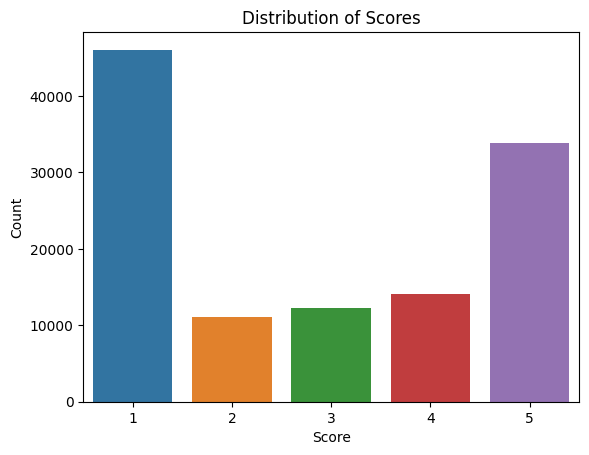

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

score_counts = df['score'].value_counts().sort_index()
sns.barplot(x=score_counts.index, y=score_counts.values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

In [8]:
reviews = df['cleaned_content'].tolist()
scores = df['score'].tolist()

# 토크나이저 생성.
tokenizer = get_tokenizer("basic_english")

# 단어 모음집 생성.
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# 리뷰 기준으로 모음집 내용 생성.
vocab = build_vocab_from_iterator(yield_tokens(reviews), specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [9]:
# 데이터셋 정의.
class ReviewDataset(Dataset):
    def __init__(self, reviews, scores, vocab, tokenizer):
        self.reviews = reviews
        self.scores = scores
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        score = self.scores[idx]
        review_tensor = torch.tensor(self.vocab(self.tokenizer(review)), dtype=torch.long)
        score_tensor = torch.tensor(score, dtype=torch.float)
        return review_tensor, score_tensor

In [10]:
# 훈련, 테스트 데이터 분할 및 데이터셋 정의
train_reviews, test_reviews, train_scores, test_scores = train_test_split(reviews, scores, test_size=0.2, random_state=42)

train_dataset = ReviewDataset(train_reviews, train_scores, vocab, tokenizer)
test_dataset = ReviewDataset(test_reviews, test_scores, vocab, tokenizer)

In [11]:
# DataLoader 정의
def collate_batch(batch):
    review_list, score_list = [], []
    for text, score in batch:
        review_list.append(text)
        score_list.append(score)
    review_list = nn.utils.rnn.pad_sequence(review_list, batch_first=True, padding_value=vocab["<pad>"])
    score_list = torch.tensor(score_list, dtype=torch.float)
    return review_list, score_list

BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [12]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

In [13]:
# 하이퍼파라미터 설정 및 모델 초기화
INPUT_DIM = len(vocab)  #단어 feature의 수
EMBEDDING_DIM = 64  # 워드벡터의 차원 수. 단어가 추상적으로 표현되는 크기
HIDDEN_DIM = 128    # 은닉층 차원 수(쉽게 말하면 모델의 일꾼)
OUTPUT_DIM = 1  # 단일 스칼라 값으로 회귀 예측. 혹은 len(set(scores))
N_LAYERS = 2    # 재귀 층 2개.
BIDIRECTIONAL = True    # 양방향. 정방향뿐만 아니라 역방향으로도 정보를 추출해 더욱 정확한 결과 예측.
DROPOUT = 0.5   # 설정 확률에 따라 뉴런 제거. 과적합 방지.
PAD_IDX = vocab["<pad>"]

In [14]:
model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [15]:
# 손실 함수와 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()  # MSE 손실 함수를 사용하여 회귀 문제로 설정

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # gpu 할당
model = model.to(device)
criterion = criterion.to(device)

In [16]:
# 모델 학습 및 평가 함수
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0  # 한 에포크당 총 손실의 누적 변수
    model.train()   # 학습 모드
    
    for text, score in iterator:    # train_loader로부터 미니배치 단위 (review, score)로 학습 데이터 가져옴.
        text, score = text.to(device), score.to(device) #GPU or CPU로 이동.
        
        optimizer.zero_grad()   # 이전 단계 기울기 초기화.
        predictions = model(text).squeeze(1)    # 모델에 텍스트 입력, 예측 수행. squeeze(1)은 불필요한 차원 제거.
        loss = criterion(predictions, score)    # 예측값, 실제값 손실 계산.
        
        loss.backward() # 역전파 수행. 손실 통해 기울기 계산.
        optimizer.step()    # 옵티마이저로 가중치 업데이트.
        
        epoch_loss += loss.item()   # 미니 배치 손실을 에포크 손실에 누적.
    
    return epoch_loss / len(iterator)   # 에포크의 평균 손실 반환

In [17]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    model.eval()    # 평가 모드, dropout 비활성화.
    
    with torch.no_grad():   # 역전파 비활성화, 기울기 계산 비활성화. 메모리 사용량 감소, 연산 속도 증가.
        for text, score in iterator:
            text, score = text.to(device), score.to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, score)
            
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)   # 최종적으로 한 에포크의 평균 손실 반환.

In [18]:
# 8. 모델 학습 및 평가 실행
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    test_loss = evaluate(model, test_dataloader, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')

Epoch: 01, Train Loss: 1.549, Test Loss: 1.088
Epoch: 02, Train Loss: 1.205, Test Loss: 1.118
Epoch: 03, Train Loss: 1.191, Test Loss: 1.120
Epoch: 04, Train Loss: 1.225, Test Loss: 1.213
Epoch: 05, Train Loss: 1.245, Test Loss: 1.109


In [21]:
def predict_review(review, model, vocab, tokenizer, device):
    model.eval()  # 평가 모드로 전환
    tokens = tokenizer(review.lower())  # 리뷰 토큰화
    token_ids = [vocab[token] for token in tokens]  # 각 토큰을 고유 정수 인덱스로 변환. vocab.set_default_index(vocab["<unk>"])로 인해 토큰이 없다면 <unk>로 변환
    text_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)  # 위 ids를 텐서 변환하여 모델에 입력할 수 있게 하고 unsqueeze(0)를 통해 배치 차원 추가. 모델이 배치 단위로 입력 받기 때문에 [batch_size, sequence_length]형태로 맞추기 위해.
    
    with torch.no_grad():
        prediction = model(text_tensor).squeeze(1)  # 입력 텐서 모델에 넣어 예측 수행. 출력은 [batchsize, 1]형태로 점수가 나와서, squeeze(1)로 예측값만 가져옴.
        
    return prediction.item()  # 예측된 점수를 스칼라 형태로 반환

In [22]:
# 새로운 리뷰 예측
new_review = "It's disgusting."
predicted_score = predict_review(new_review, model, vocab, tokenizer, device)
print(f"Predicted score for the review: {predicted_score:.2f}")

Predicted score for the review: 1.72


In [23]:
new_review = "This moive is the greatest movie the world has ever seen."    #대문자는 predict_review 함수에서 소문자로 변형.
predicted_score = predict_review(new_review, model, vocab, tokenizer, device)
print(f"Predicted score for the review: {predicted_score:.2f}")

Predicted score for the review: 4.62
